In [ ]:
!pip3 uninstall tensorflow

In [ ]:
!pip3 install --upgrade tensorflow-gpu

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
#Getting rid of all the images which cant contribute 
import cv2
import imghdr

In [5]:
train_dir = 'data/train'
val_dir = 'data/validation'

In [6]:
image_exts = ['jpeg','jpg','bmp','png']
os.listdir(train_dir)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [8]:
for image_class in os.listdir(train_dir): 
    for image in os.listdir(os.path.join(train_dir, image_class)):
        image_path = os.path.join(train_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

In [9]:
for image_class in os.listdir(val_dir): 
    for image in os.listdir(os.path.join(val_dir, image_class)):
        image_path = os.path.join(val_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
# tf.keras??

In [12]:
# tf.keras.utils.image_dataset_from_directory??

In [39]:
train_data = tf.keras.utils.image_dataset_from_directory(train_dir)
val_data = tf.keras.utils.image_dataset_from_directory(val_dir)

Found 28821 files belonging to 7 classes.
Found 7066 files belonging to 7 classes.


In [40]:
class_names = train_data.class_names
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [45]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

In [46]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [47]:
normalized_ds = train_data.map(lambda x, y: (normalization_layer(x), y))


In [49]:
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.97644


In [50]:
# fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# for idx, img in enumerate(batch[0][:4]):
#     ax[idx].imshow(img.astype(int))
#     ax[idx].title.set_text(batch[1][idx])

In [51]:
len(normalized_ds)

901

In [53]:
train_size = int(len(normalized_ds)*.8)
test_size = int(len(normalized_ds)*.2)

In [54]:
train_size + test_size

900

In [55]:
train = normalized_ds.take(train_size)
test = normalized_ds.skip(train_size).take(test_size)

In [26]:
#Building the DNN

In [58]:
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as layers

In [65]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [66]:
# model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
# model.add(MaxPooling2D())

# model.add(Conv2D(32, (3,3), 1, activation='relu'))
# model.add(MaxPooling2D())

# model.add(Conv2D(16, (3,3), 1, activation='relu'))
# model.add(MaxPooling2D())

# model.add(Flatten())

# model.add(Dense(256, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

In [67]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [68]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)       

In [69]:
logdir = 'logs'

In [70]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [71]:
history = model.fit(train_data, epochs=20, validation_data=val_data, callbacks=[tensorboard_callback])

Epoch 1/20
901/901 [==============================] - 874s 968ms/step - loss: 1.6539 - accuracy: 0.3486 - val_loss: 1.4886 - val_accuracy: 0.4345
Epoch 2/20
901/901 [==============================] - 869s 964ms/step - loss: 1.3943 - accuracy: 0.4638 - val_loss: 1.3791 - val_accuracy: 0.4731
Epoch 3/20
901/901 [==============================] - 1004s 1s/step - loss: 1.1961 - accuracy: 0.5448 - val_loss: 1.3478 - val_accuracy: 0.5006
Epoch 4/20
901/901 [==============================] - 977s 1s/step - loss: 0.9499 - accuracy: 0.6486 - val_loss: 1.4148 - val_accuracy: 0.4942
Epoch 5/20
901/901 [==============================] - 981s 1s/step - loss: 0.6371 - accuracy: 0.7692 - val_loss: 1.7520 - val_accuracy: 0.4888
Epoch 6/20
901/901 [==============================] - 834s 926ms/step - loss: 0.3639 - accuracy: 0.8744 - val_loss: 2.5065 - val_accuracy: 0.4754
Epoch 7/20
901/901 [==============================] - 849s 942ms/step - loss: 0.1972 - accuracy: 0.9382 - val_loss: 2.9793 - val_acc

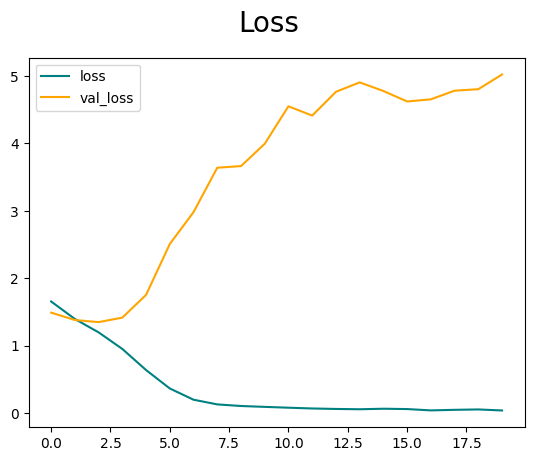

In [73]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

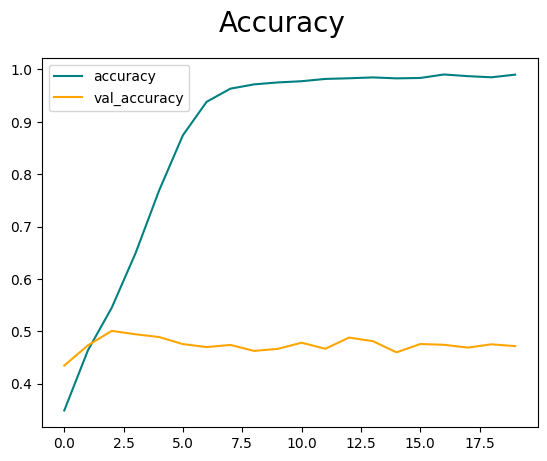

In [74]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [56]:
# Performance Review

In [38]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [39]:
precision = Precision()
recall = Recall()
binAcc = BinaryAccuracy()

In [40]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y,yhat)
    recall.update_state(y,yhat)
    binAcc.update_state(y,yhat)

1/1 [==============================] - 0s 122ms/step


In [41]:
print(f'Precision:{precision.result().numpy()}, {recall.result().numpy()}, {binAcc.result().numpy()}')

Precision:0.3333333432674408, 1.0, 0.3333333432674408


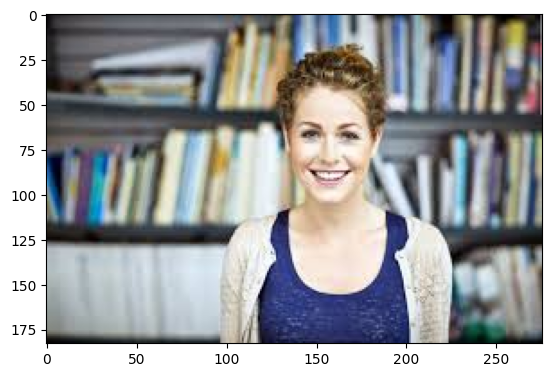

In [65]:
img = cv2.imread('happyTest.jpeg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

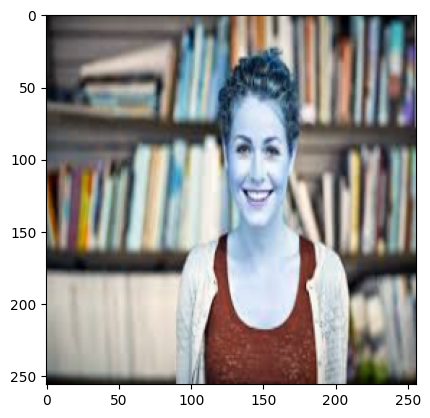

In [66]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [67]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 82ms/step


In [68]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


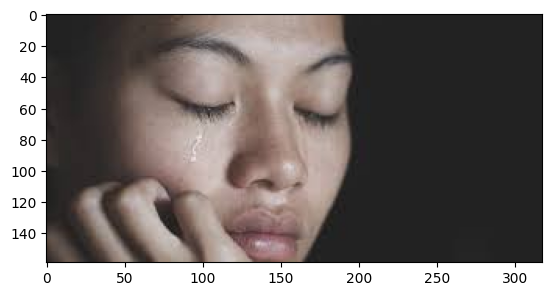

In [69]:
img = cv2.imread('sadTest.jpeg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

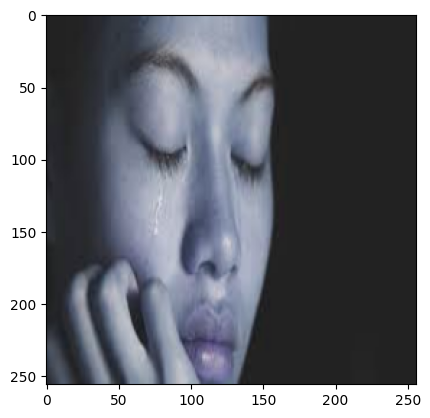

In [70]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [71]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 37ms/step


In [72]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


In [73]:
#saving the model

In [74]:
from tensorflow.keras.models import load_model

In [75]:
model.save(os.path.join('models','sentimentClassifier.h5'))